# Final Project - Andrea Fuggetta

## Spotiy song recommender

My goal is to provide song recommendations based on this dataset acquired from Kaggle [Here](https://www.kaggle.com/datasets/geomack/spotifyclassification).

I have always wondered how systems like Spotify, or Apple Music recommend songs based on my listening. So I thought this project would be an interesting subject to take.
There is a lot in this notebook and I can always improve. But for the sake of time and conciseness, I will leave some comments out assuming the reader knows the subject matter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings

from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import nltk
warnings.simplefilter("ignore")

In [2]:
# Load the data
df = pd.read_csv('data.csv')

In [3]:

# Drop columns that are not needed
df.drop(['Unnamed: 0', 'target'], axis=1, inplace=True, errors='ignore')

# Duplicates
print(f"Duplicates {df.duplicated().sum()}")
df = df.drop_duplicates()

# Show null values
print(df.isnull().sum())

# Print the info
print(df.info())
print(df.describe())
print(df.shape)

Duplicates 8
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
song_title          0
artist              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 2009 entries, 0 to 2016
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2009 non-null   float64
 1   danceability      2009 non-null   float64
 2   duration_ms       2009 non-null   int64  
 3   energy            2009 non-null   float64
 4   instrumentalness  2009 non-null   float64
 5   key               2009 non-null   int64  
 6   liveness          2009 non-null   float64
 7   loudness          2009 non-null   float64
 8   mode              2009 non-null   int64  
 9   speechiness       20

In [4]:
# Categorical data
categorical_data = df.select_dtypes(include=['object'])
print("Categorical columns: ", categorical_data.columns.tolist())

# Numeric data
numeric_data = df.select_dtypes(include=['int64', 'float64'])
print("Numeric columns: ", numeric_data.columns.tolist())


Categorical columns:  ['song_title', 'artist']
Numeric columns:  ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


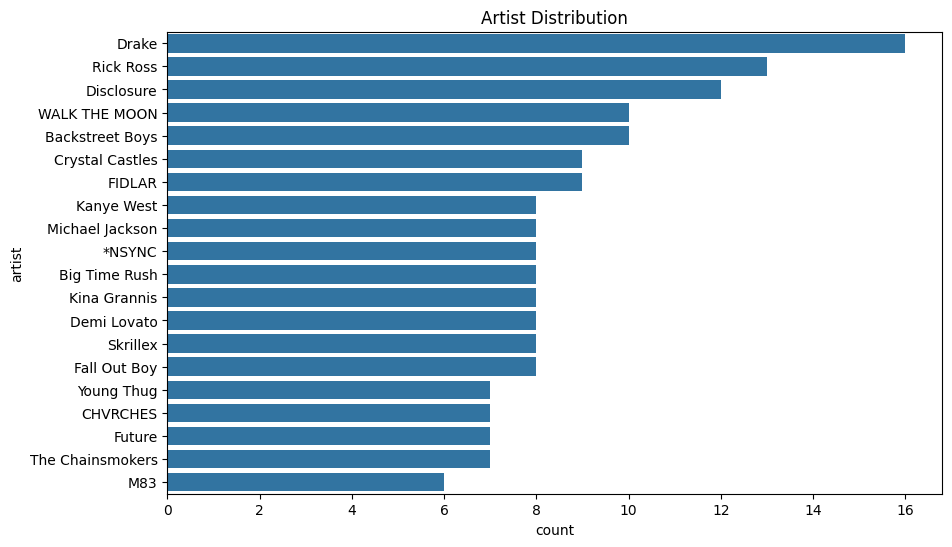

In [5]:
# Plot histogram with top 20 artist names
plt.figure(figsize=(10, 6))
sns.countplot(y='artist', data=df, order=df['artist'].value_counts()[:20].index)
plt.title('Artist Distribution')
plt.show()


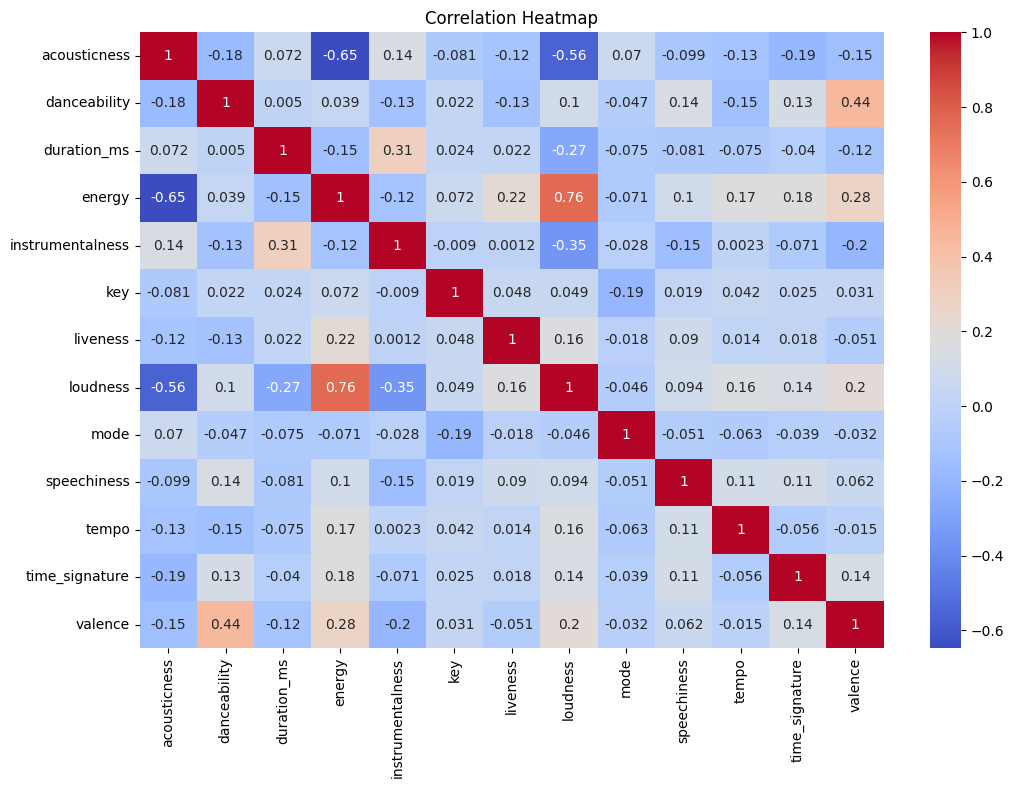

In [6]:
# We look at the correlation between the features
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [7]:
# Coalesce energy and loudness into a single feature ratio and add it to the numeric data
df['energy_loudness_ratio'] = df['energy'] / df['loudness']

# update the numeric data
numeric_data = df.select_dtypes(include=['int64', 'float64'])
print("Numeric columns: ", numeric_data.columns.tolist())

df.drop('mode', axis=1, inplace=True, errors='ignore')
df.drop('time_signature', axis=1, inplace=True, errors='ignore')

Numeric columns:  ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'energy_loudness_ratio']


In [8]:
# Divide the data into continuous and discrete columns
continuous_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'liveness', 'loudness', 'tempo', 'valence', 'speechiness', 'instrumentalness','energy_loudness_ratio']
discrete_cols = ['key']


In [9]:
# Create a StandardScaler object
scaler = StandardScaler()
# Apply scaling to the numeric features
scaled_features = scaler.fit_transform(numeric_data[continuous_cols])

# Create a new DataFrame with the scaled numeric features
df[continuous_cols] = pd.DataFrame(scaled_features, columns=df[continuous_cols].columns)

In [10]:
# Perform one-hot encoding
one_hot_encoded_data = pd.get_dummies(df, columns=discrete_cols, drop_first=True)
df = pd.concat([df.drop(columns=discrete_cols), one_hot_encoded_data], axis=1)

# Check for duplicate columns
duplicate_columns = df.columns[df.columns.duplicated()]

# Drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

df = df.dropna()

# Numeric Data
numeric_data = df.select_dtypes(include=[np.number])

numeric_data.columns

# Print the DataFrame after dropping duplicate columns
print(df.columns)

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'song_title', 'artist', 'energy_loudness_ratio', 'key_1',
       'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
       'key_10', 'key_11'],
      dtype='object')


In [11]:
# Perform PCA on the data
pca = PCA(n_components=11)
pca.fit(numeric_data)

# Get the indices of the components with the highest explained variance in descending order
top_components_indices = np.argsort(pca.explained_variance_ratio_)[::-1][:11]

# Get the corresponding column names and sort
sorted_attributes_pca = [numeric_data.columns[i] for i in top_components_indices]
final_attributes_pca = pd.DataFrame({'Attributes': sorted_attributes_pca})

# Print the final DataFrame
print(final_attributes_pca)


               Attributes
0            acousticness
1            danceability
2             duration_ms
3                  energy
4        instrumentalness
5                liveness
6                loudness
7             speechiness
8                   tempo
9                 valence
10  energy_loudness_ratio


In [12]:
# Get the top 10 attributes from PCA
pca_top_attributes = sorted_attributes_pca[:10]

# Get the 8 attributes with the highest importance based on their position in the combined list
final_attributes = pca_top_attributes[:10]

# Print the final attributes
for attribute in final_attributes:
    print(attribute)

# Select the relevant columns from numeric_data
pca_data = numeric_data[final_attributes]

# Add the 'artist' and 'song_title' columns from the data DataFrame
pca_data.insert(0, 'song_title', df['song_title'])
pca_data.insert(1, 'artist', df['artist'])

new_data = pca_data.dropna()
new_data.head()

acousticness
danceability
duration_ms
energy
instrumentalness
liveness
loudness
speechiness
tempo
valence


,song_title,artist,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,Mask Off,Future,-0.683353,1.334474,-0.507172,-1.179686,-0.407484,-0.165313,-0.457888,3.805626,1.066550,-0.855352
1,Redbone,Childish Gambino,0.043461,0.775291,0.984749,-1.536441,-0.465311,-0.345553,-0.885268,-0.144439,1.442258,0.367042
2,Xanny Family,Future,-0.590191,1.365539,-0.737583,-1.284334,-0.486830,-0.203936,-0.019597,2.210321,-1.746028,-1.312737
3,Master Of None,Beach House,1.602569,-0.771781,-0.570430,-1.636332,1.380040,-0.633936,-2.171933,-0.743240,-1.317719,-1.082021
4,Parallel Lines,Junior Boys,-0.029682,0.371437,1.789169,-0.575581,1.387364,1.598462,-1.217113,-0.256784,1.964185,1.646103


## Clustering

I will use clustering to try to organize the songs together and use this to recommend.
I will compare two models:
- K-Means: Patrition based clustering that divides the data into predefined number of clusters. Assigns data based on the nearest centroid of the cluster.
- DBSCAN: Density based clustering that identifies cluster based on areas of high density vs low density. Classifies the data into core points, border points, and noise (outliers)

In [13]:
# Ask the user for a song title
song_title = input("Enter a song title: ")

new_data['song_title'] = new_data['song_title'].str.lower()
new_data['artist'] = new_data['artist'].str.lower()

# Get the song data, while converting the song title to lowercase
song_data = new_data[new_data['song_title'].str.lower() == song_title.lower()]

# If multiple songs with the same title are found, ask the user to enter the artist name
if song_data.shape[0] > 1:
    artist_name = input("Multiple songs found. Enter the artist name: ")
    song_data = song_data[song_data['artist'].str.lower() == artist_name.lower()]

# If the song is not found, ask the user to enter a valid song title
if song_data.empty:
    print("Song not found. Please enter a valid song title.")
elif song_data.shape[0] > 1:
    # If there are still multiple songs with the same title and artist, select the first one
    song_data = song_data.iloc[0]
else:
    print(song_data)

     song_title        artist  acousticness  danceability  duration_ms  \
1219   stitches  shawn mendes     -0.102825      0.955472    -0.251553   

        energy  instrumentalness  liveness  loudness  speechiness    tempo  \
1219 -0.161746         -0.487687  0.504149  0.226825    -0.348907  0.31311   

       valence  
1219  0.998477  


## K-Means Clustering

Because the number of clusters is important, I will run multiple tests and see which one is best.

In [14]:
# Perform clustering using KMeans algorithm
def kmeans_clustering(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels_kmeans = kmeans.fit_predict(new_data.iloc[:, 2:].values)

    # Add the cluster labels as a new column in the reduced_data DataFrame
    new_data['cluster_label_kmeans'] = cluster_labels_kmeans

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    transformed_data = tsne.fit_transform(new_data.iloc[:, 2:-2])  # Exclude 'song_title', 'artist', 'cluster_label' columns

    # Create a DataFrame for t-SNE visualization
    tsne_df = pd.DataFrame(data={
        'X': transformed_data[:, 0],
        'Y': transformed_data[:, 1],
        'Cluster_Kmeans': new_data['cluster_label_kmeans'],
    })

    # Visualize K-means clustering results
    plt.figure(figsize=(7, 6))
    plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['Cluster_Kmeans'], cmap='viridis')
    plt.title('5 clusters')
    plt.show()

    # Calculate Silhouette Coefficient kmeans
    silhouette_score = metrics.silhouette_score(new_data.iloc[:, 2:-2], new_data['cluster_label_kmeans'])
    print(f'Silhouette Coefficient: {silhouette_score}')

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_score = metrics.calinski_harabasz_score(new_data.iloc[:, 2:-2], new_data['cluster_label_kmeans'])
    print(f'Calinski-Harabasz Index: {calinski_harabasz_score}')

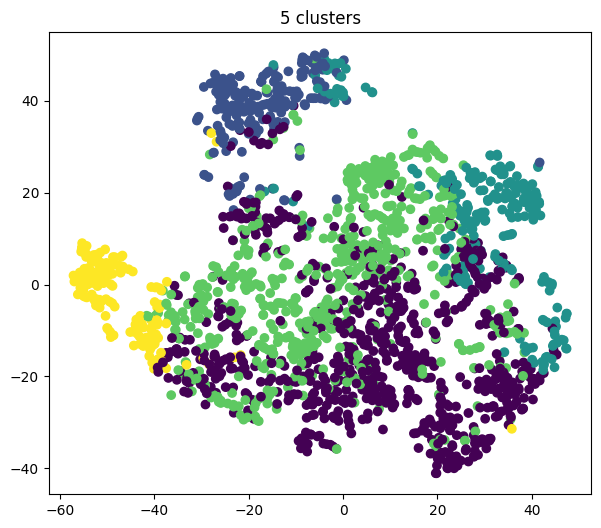

Silhouette Coefficient: 0.10366645604905929
Calinski-Harabasz Index: 298.0242342350328


In [15]:
kmeans_clustering(5)

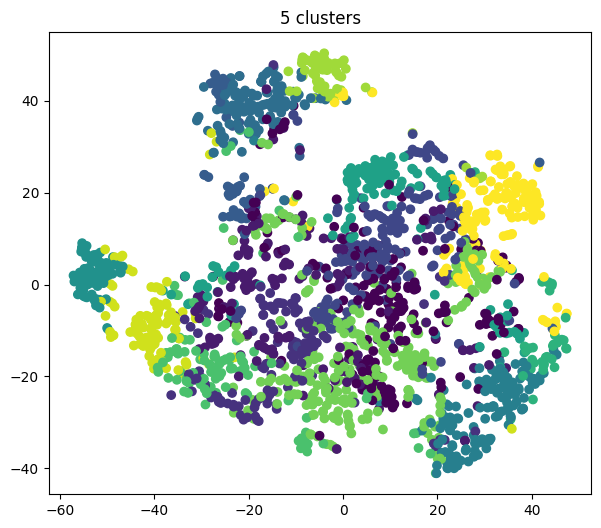

Silhouette Coefficient: 0.09002226114030415
Calinski-Harabasz Index: 202.57135746866854


In [16]:
kmeans_clustering(15)

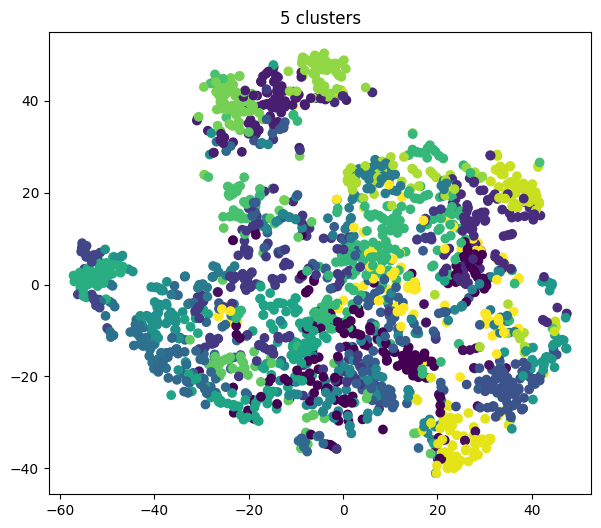

Silhouette Coefficient: 0.06623820213288079
Calinski-Harabasz Index: 148.72865571073385


In [17]:
kmeans_clustering(25)

## DBSCAN Clustering

I will run two scenarios and see which one work best.

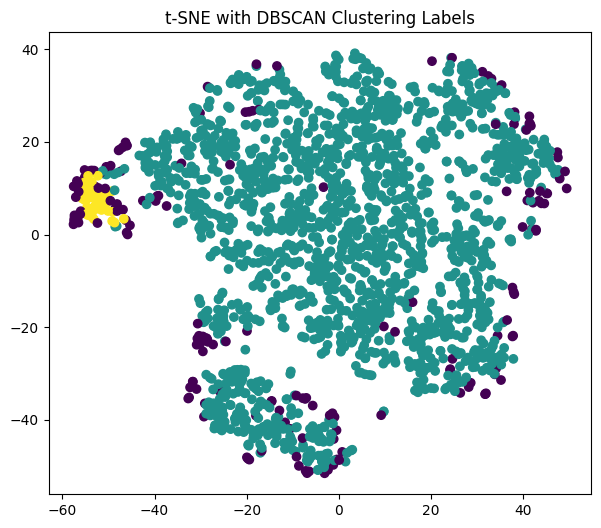

Silhouette Coefficient: 0.3106081017145226
Calinski-Harabasz Index: 136.10603832344165


In [18]:
def db_scan(eps, min_samples):
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels_dbscan = dbscan.fit_predict(new_data.iloc[:, 2:-1].values)

    # Add the cluster labels as a new column in the reduced_data_pca DataFrame
    new_data['cluster_label_dbscan'] = cluster_labels_dbscan

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    transformed_data = tsne.fit_transform(new_data.iloc[:, 2:-2])  # Exclude 'song_title', 'artist', 'cluster_label' columns

    # Create a DataFrame for t-SNE visualization
    tsne_df = pd.DataFrame(data={
        'X': transformed_data[:, 0],
        'Y': transformed_data[:, 1],
        'Cluster_DBSCAN': new_data['cluster_label_dbscan']
    })

    # Visualize DBSCAN clustering results
    plt.figure(figsize=(7, 6))
    plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['Cluster_DBSCAN'], cmap='viridis')
    plt.title('t-SNE with DBSCAN Clustering Labels')
    plt.show()

    # Calculate Silhouette Coefficient kmeans
    silhouette_score = metrics.silhouette_score(new_data.iloc[:, 2:-2], new_data['cluster_label_dbscan'])
    print(f'Silhouette Coefficient: {silhouette_score}')

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_score = metrics.calinski_harabasz_score(new_data.iloc[:, 2:-2], new_data['cluster_label_dbscan'])
    print(f'Calinski-Harabasz Index: {calinski_harabasz_score}')

db_scan(2, 10)

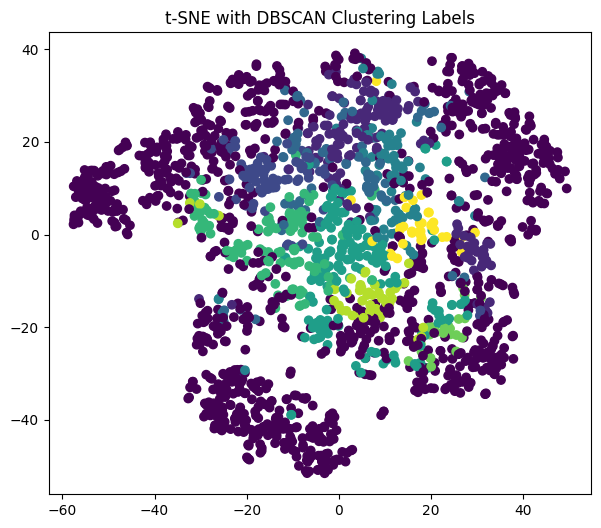

Silhouette Coefficient: -0.14869316039230046
Calinski-Harabasz Index: 33.24599155249634


In [19]:
db_scan(1.5, 25)

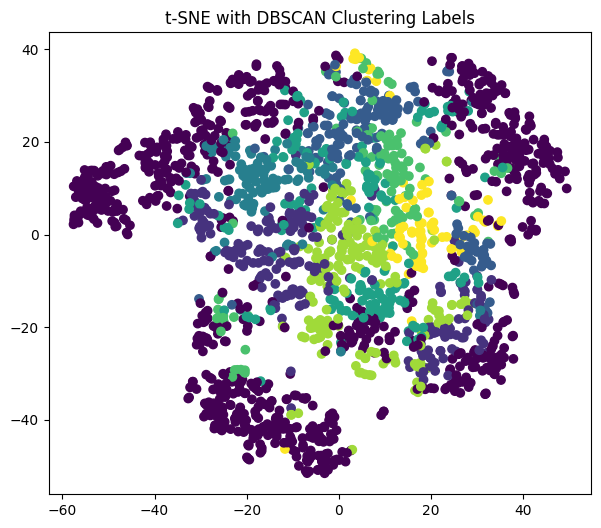

Silhouette Coefficient: -0.08127287939563259
Calinski-Harabasz Index: 53.58747928626441


In [20]:
db_scan(2, 50)

In [21]:
def cosine_similarity_kmeans(user_input_title):
    # Get the user song's features, artist, and cluster
    user_song = new_data[new_data['song_title'] == user_input_title].iloc[0]
    user_artist = user_song['artist']
    user_features = user_song[2:-1]  # Exclude 'song_title', 'artist', and 'cluster_label' columns
    user_cluster = user_song['cluster_label_kmeans']

    # Get the songs within the user song's cluster
    cluster_data = new_data[new_data['cluster_label_kmeans'] == user_cluster]

    # Calculate similarity within the user song's cluster
    similarity_scores = cosine_similarity([user_features], cluster_data.iloc[:, 2:-1])[0]

    # Set similarity score to 1 if song is by the same artist AND not the same song
    same_artist_indices = (cluster_data['artist'] == user_artist)
    similarity_scores[same_artist_indices] = 1

    # Sort songs in descending order of similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1]

    return similarity_scores, sorted_indices

def cosine_similarity_dbscan(user_input_title):
    # Get the user song's features, artist, and cluster
    user_song = new_data[new_data['song_title'] == user_input_title].iloc[0]
    user_artist = user_song['artist']
    user_features = user_song[2:-1]  # Exclude 'song_title', 'artist', and 'cluster_label' columns
    user_cluster = user_song['cluster_label_dbscan']

    # Get the songs within the user song's cluster
    cluster_data = new_data[new_data['cluster_label_dbscan'] == user_cluster]

    # Calculate similarity within the user song's cluster
    similarity_scores = cosine_similarity([user_features], cluster_data.iloc[:, 2:-1])[0]

    # Set similarity score to 1 if song is by the same artist AND not the same song
    same_artist_indices = (cluster_data['artist'] == user_artist)
    similarity_scores[same_artist_indices] = 1

    # Sort songs in descending order of similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1]

    return similarity_scores, sorted_indices

In [22]:
# Function to recommend similar songs based on user input
def recommend_similar_songs_kmeans(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = cosine_similarity_kmeans(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = new_data.loc[new_data['song_title'] == user_input_title, 'cluster_label_kmeans'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = new_data[new_data['cluster_label_kmeans'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]

In [23]:
recommended_songs_kmeans = recommend_similar_songs_kmeans(song_title)
print(recommended_songs_kmeans)

                                             song_title             artist  \
1219                                           stitches       shawn mendes   
1753                                               stay              ne-yo   
1205                                            tik tok              kesha   
63    evil friends (feat. danny brown) - jake one remix  portugal. the man   
39                               somebody's watching me           rockwell   
1202              gdfr (feat. sage the gemini & lookas)           flo rida   
1180                                     still got time               zayn   
1701                      fast car (feat. kina grannis)       kina grannis   
995                                  forgiven/forgotten        angel olsen   
515                                      we own the sky                m83   

      similarity  
1219  100.000000  
1753   99.542623  
1205   99.039455  
63     98.938349  
39     98.688940  
1202   98.628299  
1180   9

In [24]:
def euclidean_similarity_kmeans(user_input_title):
    # Get the user song's features, artist, and cluster
    user_song = new_data[new_data['song_title'] == user_input_title].iloc[0]
    user_artist = user_song['artist']
    user_features = user_song[2:-1]  # Exclude 'song_title', 'artist', and 'cluster_label' columns
    user_cluster = user_song['cluster_label_kmeans']

    # Get the songs within the user song's cluster
    cluster_data = new_data[new_data['cluster_label_kmeans'] == user_cluster]

    # Calculate similarity within the user song's cluster
    similarity_scores = []
    for _, song in cluster_data.iterrows():
        similarity = 1 / (1 + euclidean(user_features, song[2:-1]))
        similarity_scores.append(similarity)

    # Set similarity score to 1 if song is by the same artist AND not the same song
    same_artist_indices = (cluster_data['artist'] == user_artist)
    similarity_scores = np.array(similarity_scores)
    similarity_scores[same_artist_indices] = 1

    # Sort songs in descending order of similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1]

    return similarity_scores, sorted_indices

# Function to recommend similar songs based on user input
def recommend_similar_songs_kmeans(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = euclidean_similarity_kmeans(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = new_data.loc[new_data['song_title'] == user_input_title, 'cluster_label_kmeans'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = new_data[new_data['cluster_label_kmeans'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]

In [25]:
# Example usage
recommended_songs_kmeans = recommend_similar_songs_kmeans(song_title)
print(recommended_songs_kmeans)

                                             song_title             artist  \
1219                                           stitches       shawn mendes   
1753                                               stay              ne-yo   
1205                                            tik tok              kesha   
63    evil friends (feat. danny brown) - jake one remix  portugal. the man   
39                               somebody's watching me           rockwell   
1202              gdfr (feat. sage the gemini & lookas)           flo rida   
1180                                     still got time               zayn   
1701                      fast car (feat. kina grannis)       kina grannis   
995                                  forgiven/forgotten        angel olsen   
1766                        sweetest girl (dollar bill)        wyclef jean   

      similarity  
1219  100.000000  
1753   59.017788  
1205   50.098615  
63     48.391532  
39     45.952393  
1202   45.287139  
1180   4

In [26]:
# Function to recommend similar songs based on user input
def recommend_similar_songs_dbscan(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = cosine_similarity_dbscan(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = new_data.loc[new_data['song_title'] == user_input_title, 'cluster_label_dbscan'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = new_data[new_data['cluster_label_dbscan'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]


# Example usage
recommended_songs_kmeans = recommend_similar_songs_dbscan(song_title)
print(recommended_songs_kmeans)

                                             song_title             artist  \
1219                                           stitches       shawn mendes   
1753                                               stay              ne-yo   
1205                                            tik tok              kesha   
63    evil friends (feat. danny brown) - jake one remix  portugal. the man   
39                               somebody's watching me           rockwell   
1202              gdfr (feat. sage the gemini & lookas)           flo rida   
1180                                     still got time               zayn   
1701                      fast car (feat. kina grannis)       kina grannis   
995                                  forgiven/forgotten        angel olsen   
515                                      we own the sky                m83   

      similarity  
1219  100.000000  
1753   99.542623  
1205   99.039455  
63     98.938349  
39     98.688940  
1202   98.628299  
1180   9

# Conclusions

This was a fun project that thought me a lot about unsupervised learning.
I believe there are many limitations, especially the fact tat I am not including user preference into my anlysis and basing it only on similarity metrics. This might not be a conclusive result in reality but nonetheles important for myself academically.

Having said that, it seems like the recomended songs are in fact similar in genre to the one requested by the user input, which validates the approach taken in this notebook.

The K-Means model outperformed the others in general based on the different testing I've done.